<a href="https://colab.research.google.com/github/gershom1/gershom1/blob/main/chest_ct_scan_xception_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Gershom Mwale.**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [3]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
path = "/content/drive/My Drive/Research Project/Data/train"
for files in os.listdir(path):
    print(os.path.join(path,files))

/content/drive/My Drive/Research Project/Data/train/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
/content/drive/My Drive/Research Project/Data/train/normal
/content/drive/My Drive/Research Project/Data/train/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
/content/drive/My Drive/Research Project/Data/train/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [5]:
train_path = "/content/drive/My Drive/Research Project/Data/train"
test_path = "/content/drive/My Drive/Research Project/Data/test"

# Helper Functions

In [6]:
# Helper-function for joining a directory and list of filenames.
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [7]:
# Helper-function for plotting images
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(15,15))

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
# Helper-function for printing confusion matrix

# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [9]:
# Helper-function for plotting example errors
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [10]:
# Function for calculating the predicted classes of the entire test-set and calling 
# the above function to plot a few examples of mis-classified images.
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    test_generator.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = model.predict(test_generator, steps=STEPS_TEST)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [11]:
# Helper-function for loading images
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

# Working on Xception

In [12]:
# Set some important constants here
IMAGE_SIZE = 224
N_CLASSES = 4
BATCH_SIZE = 5

In [13]:
# ImageDataGenerator is needed because the dataset has no many data.
# The data augmentation can be useful to generate many augmented images from a single image

train_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'categorical')

# test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen = ImageDataGenerator(dtype='float32', preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                   class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [14]:
# save some values to be used later

cls_train = train_generator.classes
cls_test = test_generator.classes
class_names = list(train_generator.class_indices.keys())
print(class_names)
num_classes = train_generator.num_classes
print("num classes:",num_classes)

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
num classes: 4


In [15]:
image_paths_train = path_join(train_path, train_generator.filenames)
image_paths_test = path_join(test_path, test_generator.filenames)

In [16]:
STEPS_TEST = test_generator.n / BATCH_SIZE
STEPS_TEST

63.0

In [17]:
xcep_model = Xception(include_top=False, weights='imagenet', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3))

83697664/83683744 [==============================] - 1s 0us/step


In [18]:
# xcep_model.trainable = False

In [ ]:
for layer in xcep_model.layers:
    if 'block14' not in layer.name:
        layer.trainable = False

In [19]:
# Check if all layers layers are not trainable
for i, layer in enumerate(xcep_model.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_1 - True
1 block1_conv1 - True
2 block1_conv1_bn - True
3 block1_conv1_act - True
4 block1_conv2 - True
5 block1_conv2_bn - True
6 block1_conv2_act - True
7 block2_sepconv1 - True
8 block2_sepconv1_bn - True
9 block2_sepconv2_act - True
10 block2_sepconv2 - True
11 block2_sepconv2_bn - True
12 conv2d - True
13 block2_pool - True
14 batch_normalization - True
15 add - True
16 block3_sepconv1_act - True
17 block3_sepconv1 - True
18 block3_sepconv1_bn - True
19 block3_sepconv2_act - True
20 block3_sepconv2 - True
21 block3_sepconv2_bn - True
22 conv2d_1 - True
23 block3_pool - True
24 batch_normalization_1 - True
25 add_1 - True
26 block4_sepconv1_act - True
27 block4_sepconv1 - True
28 block4_sepconv1_bn - True
29 block4_sepconv2_act - True
30 block4_sepconv2 - True
31 block4_sepconv2_bn - True
32 conv2d_2 - True
33 block4_pool - True
34 batch_normalization_2 - True
35 add_2 - True
36 block5_sepconv1_act - True
37 block5_sepconv1 - True
38 block5_sepconv1_bn - True
39 block5_sepc

In [20]:
model = Sequential()
model.add(xcep_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(N_CLASSES, activation = 'softmax'))

In [21]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

In [22]:
checkpoint = ModelCheckpoint(filepath='./chest_CT_SCAN-Xception.h5',
                            monitor='val_loss',
                            mode='auto',
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=3)

In [23]:
history = model.fit(train_generator,
                    steps_per_epoch = 100,
                    epochs = 20,
                    verbose = 1,
                    validation_data = test_generator,
                    validation_steps = 50,
                    callbacks = [checkpoint, early_stopping])

Epoch 1/20
100/100 [==============================] - 614s 6s/step - loss: 1.8082 - acc: 0.4398 - val_loss: 3.1379 - val_acc: 0.3720
Epoch 2/20
100/100 [==============================] - 508s 5s/step - loss: 1.3891 - acc: 0.4960 - val_loss: 1.4097 - val_acc: 0.5120
Epoch 3/20
100/100 [==============================] - 502s 5s/step - loss: 1.2489 - acc: 0.5040 - val_loss: 28.8114 - val_acc: 0.2000
Epoch 4/20
100/100 [==============================] - 503s 5s/step - loss: 1.0735 - acc: 0.5904 - val_loss: 2.3158 - val_acc: 0.3640
Epoch 5/20
100/100 [==============================] - 506s 5s/step - loss: 1.0484 - acc: 0.6220 - val_loss: 3.2031 - val_acc: 0.2920
Epoch 5: early stopping


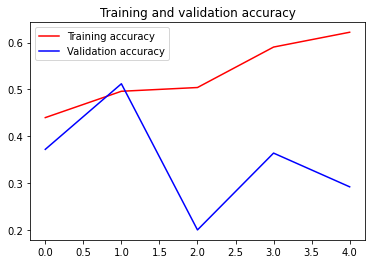

<Figure size 432x288 with 0 Axes>

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [25]:
result = model.evaluate(test_generator, steps=STEPS_TEST)

63/63 [==============================] - 61s 970ms/step - loss: 3.1324 - acc: 0.2825


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


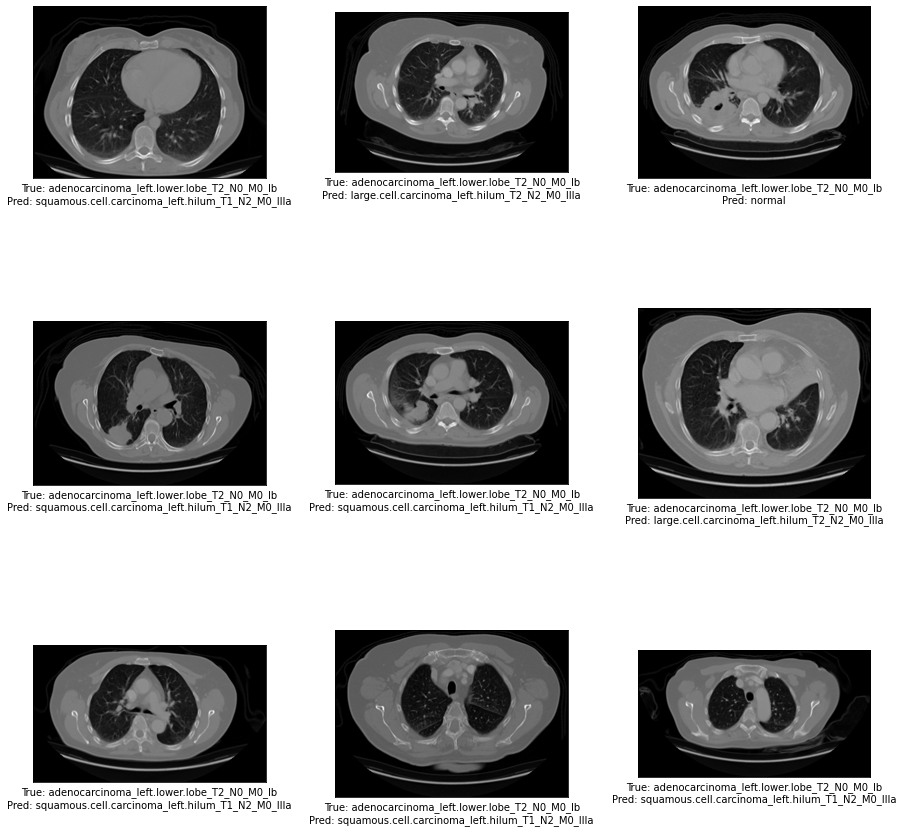

Confusion matrix:
[[36 41 22 21]
 [11 20 10 10]
 [15 21 10  8]
 [26 30 19 15]]
(0) adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
(1) large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa
(2) normal
(3) squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [ ]:
example_errors()

**LOG**<br>
13/02/2022
* Initial code